In [1]:
import sys
sys.path.append("../Modules/")
sys.path.append("../")
import os

import pandas as pd
import numpy as np

from configobj import ConfigObj
from configobj import flatten_errors
from validate import Validator
    
import logging

#fmt = 'logging.Formatter(''%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
fmt = '%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
logging.basicConfig(level=logging.INFO, format=fmt)
logger = logging.getLogger(__name__)


In [2]:
allTrialData = pd.read_pickle('../allTrialData.pickle')
# allTrialData['expansionGain'] = allTrialData['expansionGain'].astype(np.float)
# allTrialData['passingLocX'] = allTrialData['passingLocX'].astype(np.float)

# HERE IS WHERE I FLIP EYE-TO-BALL CENTER ETC

In [3]:
# flipData = True
# if( flipData):
#     allTrialData['meanEyeToBallCenterAz'] = -allTrialData['meanEyeToBallCenterAz']
#     allTrialData['meanEyeToBallEdgeAz'] = -allTrialData['meanEyeToBallEdgeAz']
#     flipData=False

In [4]:

# sessionDict = calcGazeToBallCenterError(sessionDict,'cyc','worldUp')
# sessionDict = calcGazeToBallError(sessionDict,'cyc','worldUp')


# Create an array for matlabby averaging across dimensions 

In [5]:
#fixDf_trial_block_sub = allTrialData.groupby(('subjectNumber','trialNumber','blockNumber'))

fixDf_expG_passLoc_bl_sub = allTrialData.groupby(('expansionGain',
                                                  'passingLocX',
                                                  'blockNumber',
                                                  'fileName'))

expansionGainList = list(np.sort(allTrialData.groupby('expansionGain').groups.keys()))
passingLocXList = list(np.sort(allTrialData.groupby('passingLocX').groups.keys()))
blockList = list(allTrialData.groupby('blockNumber').groups.keys())
fileNames = list(allTrialData.groupby('fileName').groups.keys())

numGain = len(expansionGainList)
numPassingLoc = len(passingLocXList)
numBlock = len(blockList)
numSub = len(fileNames)

# Initialize to an array of zeros 
azDistToCenter_gain_pass_bl_sub = np.zeros([numGain,numPassingLoc,numBlock, numSub])
azDistToEdge_gain_pass_bl_sub = np.zeros([numGain,numPassingLoc,numBlock, numSub])

for (gain,pLoc,bl,sub), data in fixDf_expG_passLoc_bl_sub:
    # Iterate through groups, while keeping track of which group we're in.
    # The tuple (gain,pLoc,bl,sub) contains the group indices
    # The variable data is a dataframe containing rows in that group 
    
    # Convert group indices to numeric indices into their value lists
    # ...what is the index of a gain of 0.5 in the expansionGainList?
    gainIdx  = [i for i, s in enumerate(expansionGainList) if gain == s]
    plocIdx  = [i for i, s in enumerate(passingLocXList) if pLoc == s]  
    blIdx  = [i for i, s in enumerate(blockList) if bl == s]
    subIdx  = [i for i, s in enumerate(fileNames) if sub == s]


    azDistToCenter_gain_pass_bl_sub[gainIdx,plocIdx,blIdx,subIdx]  = data['meanEyeToBallCenterAz'].mean()
    azDistToEdge_gain_pass_bl_sub[gainIdx,plocIdx,blIdx,subIdx]  = data['meanEyeToBallEdgeAz'].mean()

# Plot azimuthal lead/lag to ball center

In [6]:
passingLocXList

[0.4, 0.6, 0.8]

In [7]:
import matplotlib.pyplot as plt
%matplotlib notebook

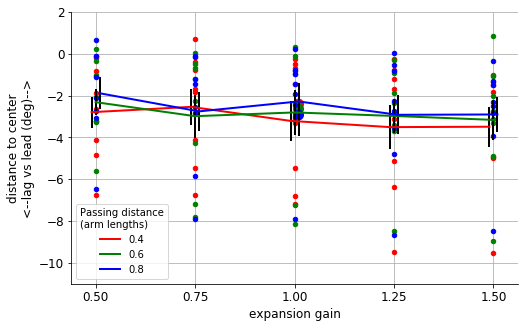

In [8]:
plotSubData = True

##############
nSubs = np.shape(azDistToCenter_gain_pass_bl_sub)[3]
meanAzOffsetB2_gain_pass_bl  = np.nanmean(azDistToCenter_gain_pass_bl_sub,axis=3)
stdErrAzOffsetB2_gain_pass_bl = np.nanstd(azDistToCenter_gain_pass_bl_sub,axis=3) / np.sqrt(nSubs)

p, ax = plt.subplots(1, 1) #sharey=True)

cList = ['r','g','b']
offsets = np.linspace(-.01,.01,3)
# Block 2
for pIdx, pVal in enumerate(passingLocXList):

    x = expansionGainList+offsets[pIdx]
    y = meanAzOffsetB2_gain_pass_bl[:,pIdx,1]
    yerr = stdErrAzOffsetB2_gain_pass_bl[:,pIdx,1]
    h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    
    ax.errorbar(x=x, 
               y=y,
               yerr=yerr,
               elinewidth=2,
               ecolor = 'k',
               fmt="none")

# Block 1
x = [1+.01] * len(meanAzOffsetB2_gain_pass_bl[2,:,0])
y = meanAzOffsetB2_gain_pass_bl[2,:,0]
yerr = stdErrAzOffsetB2_gain_pass_bl[2,pIdx,0]

ax.scatter(x=x, 
           y=y,
          s=100,
          c=cList)

ax.errorbar(x=x, 
            y=y,
            yerr=yerr,
            elinewidth=2,
            ecolor = 'k',
            fmt="none")
###

if plotSubData:
    nGain = np.shape(azDistToCenter_gain_pass_bl_sub)[0]
    nPass = np.shape(azDistToCenter_gain_pass_bl_sub)[1]
    offsets = np.linspace(-.02,.02,3)

    for gIdx, gain in enumerate(expansionGainList):
        for pIdx in range(nPass):

            ax.scatter(x=[gain]*8 ,
                       y=np.squeeze(azDistToCenter_gain_pass_bl_sub[gIdx,pIdx,1,:]),
                       s=20,
                       c=cList[pIdx])

            
plt.gcf().set_size_inches(8,5)
#ax.axes.set_title('Azimuthal distance to ball center', fontsize=15)
ax.set_ylabel('distance to center\n<--lag vs lead (deg)-->', fontsize=12)
ax.set_xlabel('expansion gain', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylim([-11,2])
plt.legend(title='Passing distance\n(arm lengths)')
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
ax.axes.set_axisbelow(True)

plt.rcParams["font.family"] = "sans-serif"
ax.set_xticks(expansionGainList)
ax.tick_params(axis='both', which='major', labelsize=12)
p.set_facecolor('w')    
plt.savefig('leadLagCenter.png', facecolor=p.get_facecolor(), transparent=True)

# Plot azimuthal lead/lag to ball edge

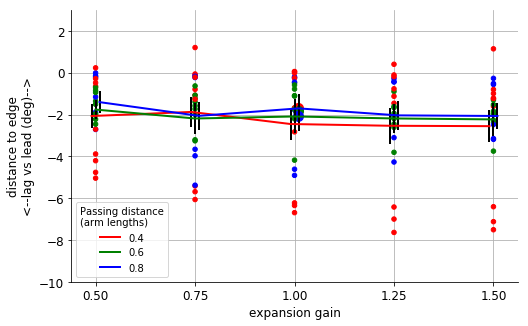

In [9]:
plotSubData = True

##############
nSubs = np.shape(azDistToEdge_gain_pass_bl_sub)[3]
meanAzOffsetB2_gain_pass_bl  = np.nanmean(azDistToEdge_gain_pass_bl_sub,axis=3)
stdErrAzOffsetB2_gain_pass_bl = np.nanstd(azDistToEdge_gain_pass_bl_sub,axis=3) / np.sqrt(nSubs)

p, ax = plt.subplots(1, 1) #sharey=True)

cList = ['r','g','b']
offsets = np.linspace(-.01,.01,3)
# Block 2
for pIdx, pVal in enumerate(passingLocXList):

    x = expansionGainList+offsets[pIdx]
    y = meanAzOffsetB2_gain_pass_bl[:,pIdx,1]
    yerr = stdErrAzOffsetB2_gain_pass_bl[:,pIdx,1]
    h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    
    ax.errorbar(x=x, 
               y=y,
               yerr=yerr,
               elinewidth=2,
               ecolor = 'k',
               fmt="none")

# Block 1
x = [1+.01] * len(meanAzOffsetB2_gain_pass_bl[2,:,0])
y = meanAzOffsetB2_gain_pass_bl[2,:,0]
yerr = stdErrAzOffsetB2_gain_pass_bl[2,pIdx,0]

ax.scatter(x=x, 
           y=y,
          s=100,
          c=cList)

ax.errorbar(x=x, 
            y=y,
            yerr=yerr,
            elinewidth=2,
            ecolor = 'k',
            fmt="none")
###

if plotSubData:
    nGain = np.shape(azDistToEdge_gain_pass_bl_sub)[0]
    nPass = np.shape(azDistToEdge_gain_pass_bl_sub)[1]
    offsets = np.linspace(-.02,.02,3)

    for gIdx, gain in enumerate(expansionGainList):
        for pIdx in range(nPass):

            ax.scatter(x=[gain]*8 ,
                       y=np.squeeze(azDistToEdge_gain_pass_bl_sub[gIdx,pIdx,1,:]),
                       s=20,
                       c=cList)

            
plt.gcf().set_size_inches(8,5)
#ax.axes.set_title('Azimuthal distance to ball edge', fontsize=15)
ax.set_ylabel('distance to edge\n<--lag vs lead (deg)-->', fontsize=12)
ax.set_xlabel('expansion gain', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylim([-10,3])
plt.legend(title='Passing distance\n(arm lengths)')
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
ax.axes.set_axisbelow(True)

plt.rcParams["font.family"] = "sans-serif"
ax.set_xticks(expansionGainList)
ax.tick_params(axis='both', which='major', labelsize=12)
p.set_facecolor('w')    
plt.savefig('leadLagEdge.png', facecolor=p.get_facecolor(), transparent=True)

### Subtract block 1 normal trials from block 1 expansion gain trials

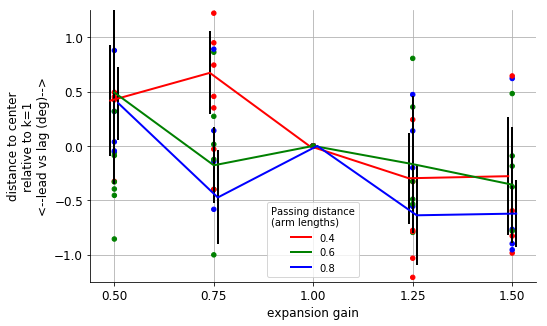

In [10]:
##### plotSubData = True
plotSubData = True

expansionGainList = np.array(np.sort(allTrialData.groupby('expansionGain').groups.keys()))

##############
nSubs = np.shape(azDistToEdge_gain_pass_bl_sub)[3]

changeInAzDist_gain_pass_sub = azDistToCenter_gain_pass_bl_sub[:,:,1,:] - azDistToCenter_gain_pass_bl_sub[2,:,1,:] 

meanAzOffsetB2_gain_pass  =  np.nanmean(changeInAzDist_gain_pass_sub,axis=2)
stdErrAzOffsetB2_gain_pass = np.nanstd(changeInAzDist_gain_pass_sub,axis=2) / np.sqrt(nSubs)

p, ax = plt.subplots(1, 1) #sharey=True)

cList = ['r','g','b']

# Block 1

# Block 2
lineHandles = []

offsets = np.linspace(-.01,.01,3)

for pIdx, pVal in enumerate(passingLocXList):

    x = expansionGainList + offsets[pIdx]
    y = meanAzOffsetB2_gain_pass[:,pIdx]
    yerr = stdErrAzOffsetB2_gain_pass[:,pIdx]
    h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    ax.errorbar(x=x, 
               y=y,
               yerr=yerr,
               elinewidth=2,
               ecolor = 'k',
               fmt="none")

if plotSubData:
    nGain = np.shape(changeInAzDist_gain_pass_sub)[0]
    nPass = np.shape(changeInAzDist_gain_pass_sub)[1]
    offsets = np.linspace(-.02,.02,3)

    for gIdx, gain in enumerate(expansionGainList):
        for pIdx in range(nPass):

            ax.scatter(x=[gain]*8,
                       y=np.squeeze(changeInAzDist_gain_pass_sub[gIdx,pIdx,:]),
                       s=20,
                       c=cList)
            
plt.gcf().set_size_inches(8,5)
#ax.axes.set_title('Azimuthal shift due to expansion (relative to k=1)', fontsize=15)
ax.set_ylabel('distance to center\nrelative to k=1\n<--lead vs lag (deg)-->', fontsize=12)
ax.set_xlabel('expansion gain', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylim([-1.25,1.25])
plt.legend(title='Passing distance\n(arm lengths)')
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
ax.axes.set_axisbelow(True)


plt.rcParams["font.family"] = "sans-serif"
ax.set_xticks(expansionGainList)
ax.tick_params(axis='both', which='major', labelsize=12)
    
#plt.savefig('relativeLeadLagCenter.png', facecolor=p.get_facecolor(), transparent=True)

In [11]:
##### plotSubData = True
plotSubData = False

expansionGainList = np.array(np.sort(allTrialData.groupby('expansionGain').groups.keys()))

##############
nSubs = np.shape(azDistToEdge_gain_pass_bl_sub)[3]

changeInAzDist_gain_pass_sub = azDistToEdge_gain_pass_bl_sub[:,:,1,:] - azDistToEdge_gain_pass_bl_sub[2,:,1,:] 

meanAzOffsetB2_gain_pass  =  np.nanmean(changeInAzDist_gain_pass_sub,axis=2)
stdErrAzOffsetB2_gain_pass = np.nanstd(changeInAzDist_gain_pass_sub,axis=2) / np.sqrt(nSubs)

p, ax = plt.subplots(1, 1) #sharey=True)

cList = ['r','g','b']

# Block 1

# Block 2
lineHandles = []

offsets = np.linspace(-.01,.01,3)

for pIdx, pVal in enumerate(passingLocXList):

    x = expansionGainList + offsets[pIdx]
    y = meanAzOffsetB2_gain_pass[:,pIdx]
    yerr = stdErrAzOffsetB2_gain_pass[:,pIdx]
    h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    ax.errorbar(x=x, 
               y=y,
               yerr=yerr,
               elinewidth=2,
               ecolor = 'k',
               fmt="none")

if plotSubData:
    nGain = np.shape(changeInAzDist_gain_pass_sub)[0]
    nPass = np.shape(changeInAzDist_gain_pass_sub)[1]
    offsets = np.linspace(-.02,.02,3)

    for gIdx, gain in enumerate(expansionGainList):
        for pIdx in range(nPass):

            ax.scatter(x=[gain]*8,
                       y=np.squeeze(changeInAzDist_gain_pass_sub[gIdx,pIdx,:]),
                       s=20,
                       c=cList)

            

plt.gcf().set_size_inches(8,5)
#ax.axes.set_title('Azimuthal shift due to expansion (relative to k=1)', fontsize=15)
ax.set_ylabel('distance to edge\nrelative to k=1\n<--lead vs lag (deg)-->', fontsize=12)
ax.set_xlabel('expansion gain', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylim([-3,2])
plt.legend(title='Passing distance\n(arm lengths)')
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
ax.axes.set_axisbelow(True)
p.set_facecolor('w')s
plt.rcParams["font.family"] = "sans-serif"
ax.set_xticks(expansionGainList)
ax.tick_params(axis='both', which='major', labelsize=12)
    
#plt.savefig('relativeLeadLagEdge.png', facecolor=p.get_facecolor(), transparent=True)

SyntaxError: invalid syntax (<ipython-input-11-e41f6eff8925>, line 67)

In [ ]:
# allTrialData.to_csv('allDataCSV.csv')

In [ ]:
#list(allTrialData.columns)
#allTrialData['ballCaughtQ']